### Load SDXL model and checkpoints

In [3]:
import sys
sys.path.append("..")

import os

import torch
import diffusers
from PIL import Image
from omegaconf import OmegaConf

from model import load_sdxl, build_encoders
from model.sdxl_pipeline import SdxlStableDiffusionLongPromptWeightingPipeline
from data.dataset import images_to_4d_tensor
from data.preprocess import make_image_face_pair_with_detection_insightface, get_insightface_analyzer, open_image


base_model_path="../../ckpt/stable-diffusion-xl-base-1.0"
checkpoint_path="../../runs/run006/ckpt/checkpoint-60000"

device="cuda"

tokenizer1, tokenizer2, text_encoder1, text_encoder2, vae, unet = load_sdxl(base_model_path)

print(f"Loading unet checkpoint from {checkpoint_path}")
unet_state_dict = torch.load(os.path.join(checkpoint_path, "pytorch_model.bin"), map_location="cpu")
unet.load_state_dict(unet_state_dict)

print(f"Building Image Encoders {checkpoint_path}")
train_config = OmegaConf.load(os.path.join(os.path.dirname(os.path.dirname(checkpoint_path)), "config.yaml"))
train_config = OmegaConf.to_container(train_config, resolve=True)
image_encoder_config = train_config["image_encoder"]
image_backbone, image_projection = build_encoders(**image_encoder_config)

print(f"Loading image_projection checkpoint from {checkpoint_path}")
image_projection_state_dict = torch.load(
    os.path.join(checkpoint_path, "pytorch_model_1.bin"), map_location="cpu"
)
image_projection.load_state_dict(image_projection_state_dict)

image_backbone_weight_path = os.path.join(checkpoint_path, "pytorch_model_2.bin")
if os.path.exists(image_backbone_weight_path):
    print(f"Loading image_backbone checkpoint from {checkpoint_path}")
    image_backbone_state_dict = torch.load(image_backbone_weight_path)
    image_backbone.load_state_dict(image_backbone_state_dict)

image_backbone.eval().to(device)
image_projection.eval().to(device)

vae.set_use_memory_efficient_attention_xformers(True)

scheduler = diffusers.EulerAncestralDiscreteScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
)

pipeline = SdxlStableDiffusionLongPromptWeightingPipeline(
    vae=vae,
    text_encoder=[text_encoder1, text_encoder2],
    tokenizer=[tokenizer1, tokenizer2],
    unet=unet,
    safety_checker=None,
    feature_extractor=None,
    requires_safety_checker=False,
    scheduler=scheduler,
)
pipeline.to(device=device, dtype=torch.bfloat16)

face_detector = get_insightface_analyzer()


The config attributes {'force_upcast': True} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Loading unet checkpoint from ../../runs/run006/ckpt/checkpoint-60000
Building Image Encoders ../../runs/run006/ckpt/checkpoint-60000
Loading image_projection checkpoint from ../../runs/run006/ckpt/checkpoint-60000


### Load face image


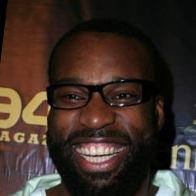

In [43]:
face_image_path = "/NFS/workspaces/dilee/projects/data/raw/img_celeba/000300.jpg"

face_image = open_image(face_image_path)

_, face, _ = make_image_face_pair_with_detection_insightface(
    face_image, face_detector, face_size_in_cropped=160, face_crop_size=196, get_mask=True
)

if face is None:
    raise RuntimeError(f"No face detected: {face_image_path}")

display(Image.fromarray(face))


### Generate

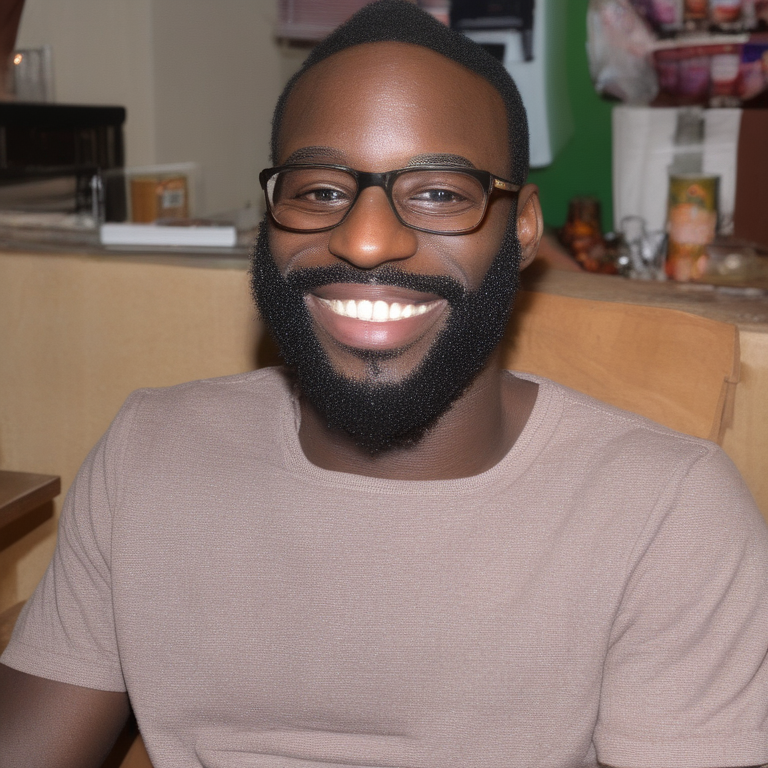

In [44]:
prompt = "A person sitting at a table."

height = 768
width = 768
sample_steps = 50
scale = 3
negative_prompt = None
init_image = None
mask = None
strength = 0.5
seed = 30


with torch.no_grad():
    face_tensor = images_to_4d_tensor([face]).to(device)
    face_encoding = image_backbone(face_tensor)
    # ensemble for multiple faces
    face_encoding = [encoding.mean(dim=0, keepdim=True) for encoding in face_encoding]
    face_embedding = image_projection(face_encoding)

generator = torch.Generator(device=pipeline.device)
generator.manual_seed(seed)

latents = pipeline(
    prompt=prompt,
    height=height,
    width=width,
    num_inference_steps=sample_steps,
    guidance_scale=scale,
    negative_prompt=negative_prompt,
    image=init_image,
    mask_image=mask,
    strength=strength,
    generator=generator,
    face_embeddings=face_embedding.to(device=pipeline.device, dtype=pipeline.dtype)
)
image = pipeline.latents_to_image(latents)[0]

display(image)